In [5]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
# !mkdir -p '/kaggle/temp/'
# #!tar -xvzf '../input/200-bird-species-with-11788-images/CUB_200_2011.tgz' --directory '/kaggle/temp/'
# !tar -xzf '../input/200-bird-species-with-11788-images/CUB_200_2011.tgz' --directory '/kaggle/temp/'

In [8]:
# import os
# for dirname, _, filenames in os.walk('./'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [1]:
#%%
import tensorflow as tf
print('TF version: ', tf.__version__)

#%% 
"""fix for issue: cuDNN failed to initialize"""
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices)>0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('...GPU set_memory_growth successfully set...')

else:
    print('...GPU set_memory_growth not set...')

#%%
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten,Softmax, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import math
#from tf_explain_modified.core.grad_cam import GradCAM
import datetime
from tqdm import tqdm # to monitor progress
import argparse
import os, sys

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


from tensorflow.keras import optimizers


# from models10 import MySubClassModel
# from codes.compute_filter_importance import save_filter_importance, test_filter_importance,test_filter_importance_in_code_method, plot_filter_importance,check_top_filter_importance,save_filter_importance_batch, check_histogram_top_filter_result
# from codes.load_cxr_dataset import create_cxr_dataframes, load_cxr_dataset
# from codes.support_functions import print_filter_classes_1, print_filter_classes_2, save_interpretable_parameters
# from codes.find_filter_class import find_filter_class
# from codes.train_counterfactual_net import train_counterfactual_net
# from codes.support_functions import get_heatmap_only

TF version:  2.3.0
...GPU set_memory_growth successfully set...


In [2]:
#%%
KAGGLE = True
parser = argparse.ArgumentParser(description='Interpretable CNN')
parser.add_argument('--interpretable',default = False)
parser.add_argument('--full_standard',default = True)## dont add extra cnn layer to be comparable with interpretable model. Make completely standalone model
parser.add_argument('--train_using_builtin_fit_method',default = True)#for training base model easily

parser.add_argument('--create_counterfactual_combined' ,default = False)## create CF model for a pretrained base model or train a new base model

parser.add_argument('--train_counterfactual_net' ,default = False)## 
parser.add_argument('--resume_counterfactual_net' ,default = False)## 
parser.add_argument('--test_counterfactual_net' ,default = False)## 
parser.add_argument('--load_counterfactual_net',default = True)


parser.add_argument('--resume', default =False) # load saved weights for base model
parser.add_argument('--pretrained', default = False) # load self-pretrained model

parser.add_argument('--find_filter_class', default = False) # load retrained model and assign class to each filter by check mean activation per filter per class

parser.add_argument('--filter_modified_directly', default = True)
parser.add_argument('--loss_compute', default = True)#False = forward only
parser.add_argument('--high_capacity_model', default = True)#
parser.add_argument('--fixed_classes', default = True)#idea 2: fine tune from forward only with fixed classes
parser.add_argument('--fixed_classes_reduce_loss', default = True)#False = forward only masked with fixed filter class. issue: 100% training accuracy but 10% testing acc

parser.add_argument('--test_filter_importance', default = False)#for testing idea 2
parser.add_argument('--save_filter_importance', default = False)#for testing idea 2
parser.add_argument('--analyze_filter_importance', default = False)#for testing idea 2
parser.add_argument('--save_filter_fmap', default = False)#save filter fmap as well
parser.add_argument('--save_top_layer', default = True)#save top layer filter data only

parser.add_argument('--visualize_fmaps', default = False)

#base model parameters
parser.add_argument('--dataset',default = 'CUB200')#mnist, cifar10, CUB200, #cxr1000, #catsvsdogs, #VOC2010
parser.add_argument('--save_directory',default = './trained_weights/')
parser.add_argument('--train',default = True)
parser.add_argument('--test', default = True)
parser.add_argument('--model',default = 'VGG16/')#myCNN, VGG16,resnet50, efficientnet
parser.add_argument('--imagenet_weights',default = True) #use imageNet pretrained VGG

parser.add_argument('--filter_category_method',default = 'own_reduce_loss')   # paper --> similar to paper implementation---assign filter with categories during training by accumulating batch-wise max activations
                                                                    # own_reduce_loss --> our idea - pre-assign filter categories during forward pass over all the data, based on pretrained weights and feature maps


#parser.add_argument('--test',default = True)
 
if KAGGLE: args = parser.parse_known_args()[0] 
else: args = parser.parse_args()

if args.interpretable:
    if args.filter_category_method=='paper':
        print('filter category assignment --> paper method')
    else:
        print('filter category assignment --> our idea')
    weights_path = args.save_directory+args.model+args.dataset+'/interpretable/filter_category_method_'+str(args.filter_category_method)
    log_path  = './logs/'+args.model+args.dataset+'/interpretable/filter_category_method_'+str(args.filter_category_method)
    filter_data_path = './create_training_data/'+args.model+args.dataset+'/interpretable/filter_category_method_'+str(args.filter_category_method)
else:
    weights_path = args.save_directory+args.model+args.dataset+'/standard'
    log_path  = './logs/'+args.model+args.dataset+'/standard'
    filter_data_path = './create_training_data/'+args.model+args.dataset+'/standard' #directory for saving filter importance training data
    
if not os.path.exists(weights_path):
    os.makedirs(weights_path)    
print('save_path: ',weights_path)

parser.add_argument('--save_path',default = weights_path)
if KAGGLE: args = parser.parse_known_args()[0] 
else: args = parser.parse_args()

if args.resume:
    print("resuming training")
#print(args)

if args.model == 'VGG16/':
    from tensorflow.keras.applications.vgg16 import VGG16,decode_predictions, preprocess_input
elif args.model == 'resnet50/':
    from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
elif args.model == 'efficientnet/':
    from tensorflow.keras.applications.efficientnet import EfficientNetB0, decode_predictions, preprocess_input


save_path:  ./trained_weights/VGG16/CUB200/standard


In [3]:
KAGGLE = False
#(for jupyterbook issue)

In [4]:
#%%
batch_size = 32
if args.dataset == 'mnist':
    num_classes=10
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = np.expand_dims(x_train,-1)
    x_test = np.expand_dims(x_test,-1)
    input_shape = (batch_size,28,28,1)
    label_map = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

elif args.dataset == 'cifar10':
    num_classes=10
    print('cifar-10 dataset')
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    input_shape = (batch_size,32,32,3)
    label_map = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

elif args.dataset == 'CUB200':
    print('CUB200-2011 dataset')
    num_classes=200
    input_shape = (batch_size,224,224,3)
    official_split=True
    lab_system=True
    if KAGGLE:
        if official_split:
            print('official split not established for training on KAGGLE')
            sys.exit()
        else:
            base_path = '/kaggle/temp/CUB_200_2011'
    if lab_system:
        base_path ='D:/Ali Tariq/CUB_200_2011'
    else:
        base_path = 'G:/CUB_200_2011/CUB_200_2011'
    
    if official_split:
        data_dir =base_path+'/train_test_split/train/'
        data_dir_test =base_path+'/train_test_split/test/'
        label_map = np.loadtxt(fname=base_path + '/classes.txt',dtype='str')
        label_map = label_map[:,1]
        print('using official split')
    else:
        data_dir =base_path+'/images/'
        label_map = np.loadtxt(fname=base_path + '/classes.txt',dtype='str')
        label_map = label_map[:,1]

elif args.dataset == 'cxr1000':
    print('CXR-1000 dataset')
    num_classes=15
    input_shape = (batch_size,224,224,3)
    label_map, train_df, test_df, valid_df = create_cxr_dataframes()
    all_labels = label_map
elif args.dataset == 'catsvsdogs':
    print('catsvsdogs dataset')
    num_classes=2
    input_shape = (batch_size,224,224,3)
    lab_system = False
    if lab_system:
        data_dir ='D:/Ali Tariq/catsvsdogs/train/'
        data_dir_test ='D:/Ali Tariq/catsvsdogs/test/'    
    else:
        data_dir ='G:/catsvsdogs/train/'
        data_dir_test ='G:/catsvsdogs/test/'

    label_map = ['cat',  'dog']

elif args.dataset == 'VOC2010':
    print('VOC2010-animals dataset')
    num_classes=6
    input_shape = (batch_size,224,224,3)
    lab_system = False
    if lab_system:
        data_dir ='D:/Ali Tariq/VOCdevkit/VOC_animals/'
        #data_dir_test ='D:/Ali Tariq/catsvsdogs/test/'    
    else:
        #data_dir ='G:/VOCdevkit/VOC_animals_one/'
        data_dir ='G:/VOCdevkit/VOC_animals/'
        #data_dir_test ='G:/catsvsdogs/test/'

    label_map = ['bird',  'cat', 'cow', 'dog', 'horse', 'sheep']#['cat']#

else:
    print('unknown dataset')
    sys.exit()

CUB200-2011 dataset
using official split


In [5]:
label_map

array(['001.Black_footed_Albatross', '002.Laysan_Albatross',
       '003.Sooty_Albatross', '004.Groove_billed_Ani',
       '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet',
       '008.Rhinoceros_Auklet', '009.Brewer_Blackbird',
       '010.Red_winged_Blackbird', '011.Rusty_Blackbird',
       '012.Yellow_headed_Blackbird', '013.Bobolink',
       '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting',
       '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird',
       '020.Yellow_breasted_Chat', '021.Eastern_Towhee',
       '022.Chuck_will_Widow', '023.Brandt_Cormorant',
       '024.Red_faced_Cormorant', '025.Pelagic_Cormorant',
       '026.Bronzed_Cowbird', '027.Shiny_Cowbird', '028.Brown_Creeper',
       '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo',
       '032.Mangrove_Cuckoo', '033.Yellow_billed_Cuckoo',
       '034.Gray_crowned_Rosy_Finch', '035.Purple_Finch',
       '036.Northern_Flicker', '037.Acadian_Flycatcher',
       '038.Grea

In [6]:
#%%
if args.imagenet_weights:
    print('using imagenet_weights')

    if args.dataset == 'cifar10':
        imgDataGen = ImageDataGenerator(preprocessing_function = preprocess_input)
                                        #rescale = 1./255)

        train_gen = imgDataGen.flow(x_train, y_train, batch_size = batch_size,shuffle= False)
        test_gen  = imgDataGen.flow(x_test, y_test, batch_size = batch_size,shuffle= False)
    else:
        augment = False
        if not augment:
            imgDataGen = ImageDataGenerator(preprocessing_function = preprocess_input, 
                                            #rescale = 1./255,
                                            validation_split=0.1)
        else:
            imgDataGen = ImageDataGenerator(preprocessing_function = preprocess_input, 
                                        #rescale = 1./255,
                                        validation_split=0.1,
                                        
                              height_shift_range= 0.2, 
                              width_shift_range=0.2, 
                              rotation_range=15, 
                              shear_range = 0.2,
                              fill_mode = 'nearest',#''nearest#reflect
                              zoom_range=0.2)
        
        train_gen = imgDataGen.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=True,
                                seed=None,
                                subset='training',
                                interpolation='nearest')#,
                                #all classes for base model; binary classes for CF model
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = label_map)
        test_gen  = imgDataGen.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=False,
                                seed=None,
                                subset='validation',
                                interpolation='nearest')#,
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                               # classes = label_map)
        
        # for visualization, dont use preprocessed image
        imgDataGen_nopreprocess = ImageDataGenerator(#preprocessing_function = preprocess_input, 
                                        rescale = 1./255,
                                        validation_split=0.1)
        
        train_gen_nopreprocess = imgDataGen_nopreprocess.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=True,
                                seed=None,
                                subset='training',
                                interpolation='nearest'),
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = label_map)
        test_gen_nopreprocess  = imgDataGen_nopreprocess.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=False,
                                seed=None,
                                subset='validation',
                                interpolation='nearest'),
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = label_
        if args.dataset == 'CUB200' and official_split:
            #actual unseen test set
            imgDataGen_official_split = ImageDataGenerator(preprocessing_function = preprocess_input)
            actual_test_gen  = imgDataGen_official_split.flow_from_directory(data_dir_test,
                            target_size=(input_shape[1], input_shape[2]),
                            color_mode='rgb',
                            class_mode='categorical',
                            batch_size=batch_size,
                            shuffle=False,
                            seed=None,
                            #subset='validation',
                            interpolation='nearest')
            imgDataGen_official_split_nopreprocess = ImageDataGenerator(rescale = 1./255)
            actual_test_gen_nopreprocess  = imgDataGen_official_split_nopreprocess.flow_from_directory(data_dir_test,
                            target_size=(input_shape[1], input_shape[2]),
                            color_mode='rgb',
                            class_mode='categorical',
                            batch_size=batch_size,
                            shuffle=False,
                            seed=None,
                            #subset='validation',
                            interpolation='nearest')
elif args.dataset == 'cxr1000':
    train_gen, test_gen, valid_gen = load_cxr_dataset(train_df, test_df, valid_df, all_labels, batch_size)
    
else:
    print('not using imagenet_weights')

    imgDataGen = ImageDataGenerator(rescale = 1./255)

    train_gen = imgDataGen.flow(x_train, y_train, batch_size = batch_size,shuffle= False)
    test_gen  = imgDataGen.flow(x_test, y_test, batch_size = batch_size,shuffle= False)



using imagenet_weights
Found 5400 images belonging to 200 classes.
Found 594 images belonging to 200 classes.
Found 5400 images belonging to 200 classes.
Found 594 images belonging to 200 classes.
Found 5794 images belonging to 200 classes.
Found 5794 images belonging to 200 classes.


In [7]:
#%%
if args.imagenet_weights:
    print('loading VGG model')
    if args.dataset == 'cxr1000':
        tr = 1
        if tr:
            print('using imagenet weights for CXR dataset')
            vgg = VGG16(weights='imagenet',include_top = True)#top needed to get output dimensions at each layer
                # EfficientNetB0(include_top=True,
                #                weights=None,
                #                input_shape=img_shape,
                #                classes=len(all_labels),
                #                classifier_activation='sigmoid')
            base_model = tf.keras.Model(vgg.input,vgg.layers[-6].output)
            #model.compile(optimizer = optimizers.RMSprop(), loss = 'binary_crossentropy',#adam #weighted_binary_crossentropy #lr=0.001/2#binary_crossentropy
                                       #metrics = ['binary_accuracy'])#,tf.keras.metrics.AUC()])
        else:
            print('loading saved model - NOT IMPLEMENTED YET')
            #model = load_model('../input/efnb0-saved-weights/xray_class_EfficientNetB4_15_class_CEL_heatmap_imagenet_pretrained_weights.05-0.1807.hdf5')
        
        #model.summary()
    elif args.dataset == 'cifar10':
        print('using imagenet weights for cifar10 dataset')
        vgg = VGG16(weights='imagenet',include_top = False,input_shape=(32,32,3))#top needed to get output dimensions at each layer
        freeze=True
        if freeze:
            for layer in vgg.layers:
                layer.trainable = False
        base_model = tf.keras.Model(vgg.input,vgg.layers[-2].output)
    elif args.dataset == 'CUB200':
        if args.model == 'VGG16/':
           print('using VGG16 imagenet weights for CUB200 dataset')
           vgg = VGG16(weights='imagenet',include_top = False,input_shape=(224,224,3))#top needed to get output dimensions at each layer
           freeze=True
           if freeze:
               for layer in vgg.layers:
                   print (layer.name)
                   if layer.name == '----block5_conv3': continue
                   else: layer.trainable = False
           base_model = tf.keras.Model(vgg.input,vgg.layers[-2].output)
        elif args.model == 'resnet50/':
           print('using resnet50 imagenet weights for CUB200 dataset')
           vgg = ResNet50(weights='imagenet',include_top = False,input_shape=(224,224,3))#top needed to get output dimensions at each layer
           freeze=True
           if freeze:
               for layer in vgg.layers:
                   print (layer.name)
                   if layer.name == '----block5_conv3': continue
                   else: layer.trainable = False
           base_model = tf.keras.Model(vgg.input,vgg.output)
        elif args.model == 'efficientnet/':
               print('using efficientnet imagenet weights for CUB200 dataset')
               vgg = EfficientNetB0(weights='imagenet',include_top = False,input_shape=(224,224,3))#top needed to get output dimensions at each layer
               freeze=True
               if freeze:
                   for layer in vgg.layers:
                       print (layer.name)
                       if layer.name == '----block5_conv3': continue
                       else: layer.trainable = False
               base_model = tf.keras.Model(vgg.input,vgg.output)
    elif args.dataset == 'catsvsdogs':
        print('using imagenet weights for catsvsdogs dataset')
        vgg = VGG16(weights='imagenet',include_top = False,input_shape=(224,224,3))#top needed to get output dimensions at each layer
        freeze=True
        if freeze:
            for layer in vgg.layers:
                layer.trainable = False
        base_model = tf.keras.Model(vgg.input,vgg.layers[-2].output)
    elif args.dataset == 'VOC2010':
        print('using imagenet weights for VOC2010-animals dataset')
        vgg = VGG16(weights='imagenet',include_top = False,input_shape=(224,224,3))#top needed to get output dimensions at each layer
        freeze=True
        if freeze:
            for layer in vgg.layers:
                layer.trainable = False
        base_model = tf.keras.Model(vgg.input,vgg.layers[-2].output)
else:
    #base_model = VGG16(weights=None,include_top = False)
    base_model = MyFunctionalModel()


loading VGG model
using VGG16 imagenet weights for CUB200 dataset
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [8]:
base_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [9]:
#%% create base model
if args.full_standard:
    top_filters = base_model.output_shape[3] # flters in top conv layer (512 for VGG)
    fmatrix = tf.keras.layers.Input(shape=(top_filters))
    #flag = tf.keras.layers.Input(shape=(1))
    
    if args.model == 'VGG16/':
        x =  MaxPool2D()(base_model.output)
    elif args.model == 'resnet50/':
        x =  base_model.output
    elif args.model == 'efficientnet/':
        x =  base_model.output
    mean_fmap = GlobalAveragePooling2D()(x)
    

    
    #modify base model (once it has been pre-trained separately) to be used with CF model later
    if args.create_counterfactual_combined:
        #modified_fmap = tf.cond(tf.reduce_sum(fmatrix)>511, lambda: mean_fmap, lambda: mean_fmap*fmatrix)#modified_fmap = mean_fmap*fmatrix
        modified_fmap = mean_fmap*fmatrix
        pre_softmax = Dense(num_classes,activation=None)(modified_fmap)
        x = tf.keras.layers.Activation('softmax')(pre_softmax)
        model = tf.keras.Model(inputs=[base_model.input, fmatrix], outputs= [x,base_model.output, mean_fmap, modified_fmap,pre_softmax],name='VGG_base_model')
        default_fmatrix = tf.ones((train_gen.batch_size,base_model.output.shape[3]))
    else:
        x = tf.keras.layers.Dropout(0.5)(mean_fmap)
        
        #x = Dense(512,activation='relu')(x)
        #x = tf.keras.layers.Dropout(0.2)(x)
        
        #x = Dense(512,activation='relu')(x)

        x = Dense(num_classes,activation='softmax')(x)
        if args.train_using_builtin_fit_method:
            model = tf.keras.Model(inputs=base_model.input, outputs= [x])#, base_model.output])
        else:
            model = tf.keras.Model(inputs=base_model.input, outputs= [x, base_model.output])
else:
    model = MySubClassModel(num_classes=num_classes, base_model=base_model, args=args)
    #model = base_model
    model(tf.zeros(input_shape))
    #model.build(input_shape = input_shape)

model.summary()

#model.load_weights('./trained_weights/VGG16/CUB200/standard/model.09-2.3280.hdf5')
#load saved weights
if args.resume:
    #model.load_weights('./trained_weights/myCNN/cifar10/standard/model.hdf5')
    #model.load_weights('./trained_weights/myCNN/cifar10/interpretable/filter_category_method_paper/from_pretrained_model.hdf5')
    model.load_weights(filepath=weights_path+'/model.hdf5')
    #model.load_weights('./trained_weights/myCNN/cifar10/interpretable/filter_category_method_paper/model.hdf5')

    print("weights loaded")
if args.pretrained:
    model.load_weights('./trained_weights/myCNN/cifar10/standard/model.hdf5')
    print("pretrained weights loaded")

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

Epoch 1/50
169/169 [==============================] - ETA: 0s - loss: 16.7583 - accuracy: 0.0424
Epoch 00001: val_accuracy improved from -inf to 0.18350, saving model to ./trained_weights/VGG16/CUB200/standard\model_transfer.01-6.4392.hdf5
169/169 [==============================] - 32s 190ms/step - loss: 16.7583 - accuracy: 0.0424 - val_loss: 6.4392 - val_accuracy: 0.1835
Epoch 2/50
169/169 [==============================] - ETA: 0s - loss: 9.9812 - accuracy: 0.1344
Epoch 00002: val_accuracy improved from 0.18350 to 0.30303, saving model to ./trained_weights/VGG16/CUB200/standard\model_transfer.02-4.6063.hdf5
169/169 [==============================] - 28s 164ms/step - loss: 9.9812 - accuracy: 0.1344 - val_loss: 4.6063 - val_accuracy: 0.3030
Epoch 3/50
169/169 [==============================] - ETA: 0s - loss: 7.7155 - accuracy: 0.2154
Epoch 00003: val_accuracy improved from 0.30303 to 0.36869, saving model to ./trained_weights/VGG16/CUB200/standard\model_transfer.03-4.0785.hdf5
169/169

Epoch 26/50
169/169 [==============================] - ETA: 0s - loss: 2.4963 - accuracy: 0.5937
Epoch 00026: val_accuracy did not improve from 0.54714
169/169 [==============================] - 45s 264ms/step - loss: 2.4963 - accuracy: 0.5937 - val_loss: 3.1411 - val_accuracy: 0.5236
Epoch 27/50
169/169 [==============================] - ETA: 0s - loss: 2.4725 - accuracy: 0.5933
Epoch 00027: val_accuracy did not improve from 0.54714
169/169 [==============================] - 46s 272ms/step - loss: 2.4725 - accuracy: 0.5933 - val_loss: 3.0041 - val_accuracy: 0.5471
Epoch 28/50
169/169 [==============================] - ETA: 0s - loss: 2.4845 - accuracy: 0.5963
Epoch 00028: val_accuracy did not improve from 0.54714
169/169 [==============================] - 45s 266ms/step - loss: 2.4845 - accuracy: 0.5963 - val_loss: 2.9128 - val_accuracy: 0.5202
Epoch 29/50
169/169 [==============================] - ETA: 0s - loss: 2.4033 - accuracy: 0.6028
Epoch 00029: val_accuracy did not improve fro

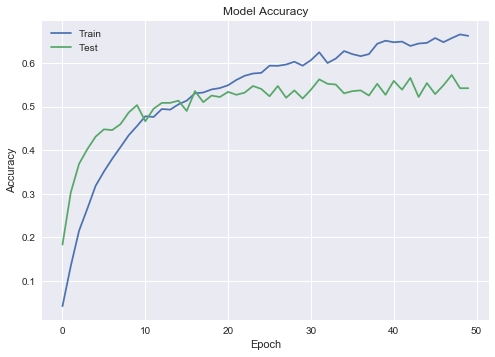

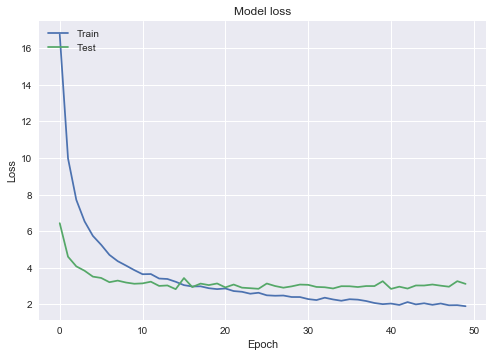

In [10]:
#%% Trains for 5 epochs.
if args.train_using_builtin_fit_method:

    model.compile(optimizer=optimizers.SGD(lr=0.01/10, momentum = 0.9), 
                  loss=[categorical_crossentropy], 
                  metrics=['accuracy'])


    #%%
    save_path=weights_path+'/model_transfer.{epoch:02d}-{val_loss:.4f}.hdf5'
    checkpoint = ModelCheckpoint(save_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only = True)
    callbacks_list = [checkpoint]
    #%%
    history = model.fit(train_gen, epochs=50, verbose=1, callbacks=callbacks_list, validation_data=test_gen, shuffle=True)
    
    plt.style.use('seaborn')
    #plt.style.available
    #['fivethirtyeight',
     #'seaborn-pastel',
     #'seaborn-whitegrid',
     #'ggplot',
     #'grayscale']
    
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plt.savefig(fname='model_accuracy_'+db+'.png')
    
    # summarize history for loss
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plt.savefig(fname='model_loss_'+db+'.png')
    
    #%% stop execution
    #sys.exit()

In [11]:
model.save_weights(filepath=weights_path+"/model_transfer_epoch_50.hdf5")

In [17]:
EfficientNetB0

<function tensorflow.python.keras.applications.efficientnet.EfficientNetB0(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax', **kwargs)>

# **Now fine tune all layers at small learning rate**

# enable augmentation for increasing regularization for fine-tuning step

In [10]:
if args.imagenet_weights:
    print('using imagenet_weights')

    if args.dataset == 'cifar10':
        imgDataGen = ImageDataGenerator(preprocessing_function = preprocess_input)
                                        #rescale = 1./255)

        train_gen = imgDataGen.flow(x_train, y_train, batch_size = batch_size,shuffle= False)
        test_gen  = imgDataGen.flow(x_test, y_test, batch_size = batch_size,shuffle= False)
    else:
        augment = True
        if not augment:
            imgDataGen = ImageDataGenerator(preprocessing_function = preprocess_input, 
                                            #rescale = 1./255,
                                            validation_split=0.1)
        else:
            imgDataGen = ImageDataGenerator(preprocessing_function = preprocess_input, 
                                        #rescale = 1./255,
                                        validation_split=0.1,
                                        
                              height_shift_range= 0.2, 
                              width_shift_range=0.2, 
                              rotation_range=15, 
                              shear_range = 0.2,
                              fill_mode = 'nearest',#''nearest#reflect
                              zoom_range=0.2)
        
        train_gen = imgDataGen.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=True,
                                seed=None,
                                subset='training',
                                interpolation='nearest')#,
                                #all classes for base model; binary classes for CF model
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = label_map)
        test_gen  = imgDataGen.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=False,
                                seed=None,
                                subset='validation',
                                interpolation='nearest')#,
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                               # classes = label_map)
        
        # for visualization, dont use preprocessed image
        imgDataGen_nopreprocess = ImageDataGenerator(#preprocessing_function = preprocess_input, 
                                        rescale = 1./255,
                                        validation_split=0.1)
        
        train_gen_nopreprocess = imgDataGen_nopreprocess.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=True,
                                seed=None,
                                subset='training',
                                interpolation='nearest'),
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = label_map)
        test_gen_nopreprocess  = imgDataGen_nopreprocess.flow_from_directory(data_dir,
                                target_size=(input_shape[1], input_shape[2]),
                                color_mode='rgb',
                                class_mode='categorical',
                                batch_size=batch_size,
                                shuffle=False,
                                seed=None,
                                subset='validation',
                                interpolation='nearest'),
                                #classes = ['cat', 'dog'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = ['cat'] if args.train_counterfactual_net else label_map)#['cat', 'dog'])
                                #classes = label_map)
        if args.dataset == 'CUB200' and official_split:
            #actual unseen test set
            imgDataGen_official_split = ImageDataGenerator(preprocessing_function = preprocess_input)
            actual_test_gen  = imgDataGen_official_split.flow_from_directory(data_dir_test,
                            target_size=(input_shape[1], input_shape[2]),
                            color_mode='rgb',
                            class_mode='categorical',
                            batch_size=batch_size,
                            shuffle=False,
                            seed=None,
                            #subset='validation',
                            interpolation='nearest')
            imgDataGen_official_split_nopreprocess = ImageDataGenerator(rescale = 1./255)
            actual_test_gen_nopreprocess  = imgDataGen_official_split_nopreprocess.flow_from_directory(data_dir_test,
                            target_size=(input_shape[1], input_shape[2]),
                            color_mode='rgb',
                            class_mode='categorical',
                            batch_size=batch_size,
                            shuffle=False,
                            seed=None,
                            #subset='validation',
                            interpolation='nearest')                            
elif args.dataset == 'cxr1000':
    train_gen, test_gen, valid_gen = load_cxr_dataset(train_df, test_df, valid_df, all_labels, batch_size)
    
else:
    print('not using imagenet_weights')

    imgDataGen = ImageDataGenerator(rescale = 1./255)

    train_gen = imgDataGen.flow(x_train, y_train, batch_size = batch_size,shuffle= False)
    test_gen  = imgDataGen.flow(x_test, y_test, batch_size = batch_size,shuffle= False)

using imagenet_weights
Found 5400 images belonging to 200 classes.
Found 594 images belonging to 200 classes.
Found 5400 images belonging to 200 classes.
Found 594 images belonging to 200 classes.
Found 5794 images belonging to 200 classes.
Found 5794 images belonging to 200 classes.


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

Epoch 15/150
169/169 [==============================] - ETA: 0s - loss: 0.4990 - accuracy: 0.8478
Epoch 00015: val_accuracy did not improve from 0.67003
169/169 [==============================] - 95s 564ms/step - loss: 0.4990 - accuracy: 0.8478 - val_loss: 1.4062 - val_accuracy: 0.6448
Epoch 16/150
169/169 [==============================] - ETA: 0s - loss: 0.4640 - accuracy: 0.8556
Epoch 00016: val_accuracy did not improve from 0.67003
169/169 [==============================] - 94s 555ms/step - loss: 0.4640 - accuracy: 0.8556 - val_loss: 1.4301 - val_accuracy: 0.6380
Epoch 17/150
169/169 [==============================] - ETA: 0s - loss: 0.4202 - accuracy: 0.8704
Epoch 00017: val_accuracy did not improve from 0.67003
169/169 [==============================] - 94s 556ms/step - loss: 0.4202 - accuracy: 0.8704 - val_loss: 1.4476 - val_accuracy: 0.6431
Epoch 18/150
169/169 [==============================] - ETA: 0s - loss: 0.4064 - accuracy: 0.8694
Epoch 00018: val_accuracy did not improve

Epoch 43/150
169/169 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9496
Epoch 00043: val_accuracy did not improve from 0.69360
169/169 [==============================] - 91s 537ms/step - loss: 0.1675 - accuracy: 0.9496 - val_loss: 1.5269 - val_accuracy: 0.6717
Epoch 44/150
169/169 [==============================] - ETA: 0s - loss: 0.1563 - accuracy: 0.9515
Epoch 00044: val_accuracy did not improve from 0.69360
169/169 [==============================] - 92s 543ms/step - loss: 0.1563 - accuracy: 0.9515 - val_loss: 1.5210 - val_accuracy: 0.6684
Epoch 45/150
169/169 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.9383
Epoch 00045: val_accuracy did not improve from 0.69360
169/169 [==============================] - 93s 550ms/step - loss: 0.1753 - accuracy: 0.9383 - val_loss: 1.5173 - val_accuracy: 0.6650
Epoch 46/150
169/169 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9498
Epoch 00046: val_accuracy did not improve

Epoch 100/150
169/169 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.9796
Epoch 00100: val_accuracy did not improve from 0.70370
169/169 [==============================] - 90s 530ms/step - loss: 0.0659 - accuracy: 0.9796 - val_loss: 1.7503 - val_accuracy: 0.6751
Epoch 101/150
169/169 [==============================] - ETA: 0s - loss: 0.0655 - accuracy: 0.9791
Epoch 00101: val_accuracy did not improve from 0.70370
169/169 [==============================] - 93s 548ms/step - loss: 0.0655 - accuracy: 0.9791 - val_loss: 1.6029 - val_accuracy: 0.6869
Epoch 102/150
169/169 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9806
Epoch 00102: val_accuracy did not improve from 0.70370
169/169 [==============================] - 92s 544ms/step - loss: 0.0638 - accuracy: 0.9806 - val_loss: 1.7257 - val_accuracy: 0.6801
Epoch 103/150
169/169 [==============================] - ETA: 0s - loss: 0.0837 - accuracy: 0.9757
Epoch 00103: val_accuracy did not imp

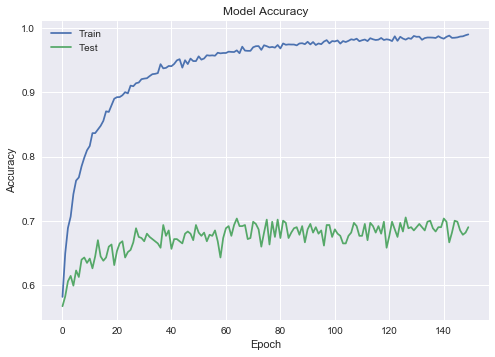

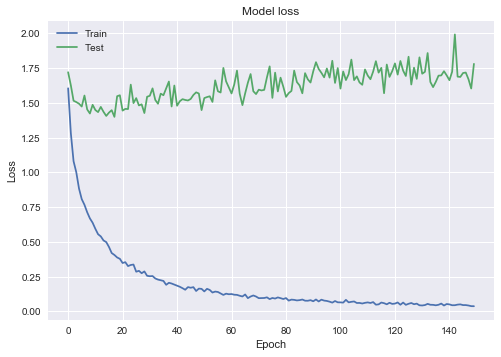

In [11]:
#%% Trains for 5 epochs.
if args.train_using_builtin_fit_method:
    model.trainable = True
    model.compile(optimizer=optimizers.SGD(lr=0.001/10, momentum = 0.9), 
                  loss=[categorical_crossentropy], 
                  metrics=['accuracy'])
    model.summary()
    
    model.load_weights(filepath=weights_path+'/model_transfer_epoch_50.hdf5')
    
    #%%
    save_path=weights_path+'/model_fine_tune.{epoch:02d}-{val_loss:.4f}.hdf5'
    checkpoint = ModelCheckpoint(save_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only = True)
    callbacks_list = [checkpoint]
    #%%
    history = model.fit(train_gen, epochs=150, verbose=1, callbacks=callbacks_list, validation_data=test_gen, shuffle=True)
    
    plt.style.use('seaborn')
    #plt.style.available
    #['fivethirtyeight',
     #'seaborn-pastel',
     #'seaborn-whitegrid',
     #'ggplot',
     #'grayscale']
    
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plt.savefig(fname='model_accuracy_'+db+'.png')
    
    # summarize history for loss
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plt.savefig(fname='model_loss_'+db+'.png')
    
    #%% stop execution
    #sys.exit()

In [12]:
model.save_weights(filepath=weights_path+"/model_fine_tune_epoch_150.hdf5")

In [15]:
#test accuracy on unseen data
if args.dataset == 'CUB200' and official_split:
    #load best weights
    model.load_weights(filepath=weights_path+'/model_fine_tune.127-1.6321.hdf5')
    #model.load_weights(filepath=weights_path+'/model_fine_tune_epoch_150.hdf5')
    
    #model.evaluate(actual_test_gen,verbose=1)
     
    pred_probs= model.predict(actual_test_gen,verbose=1)
    
    pred_classes = np.argmax(pred_probs,1)
    #actual_classes = np.argmax(test_gen.classes,1)
    actual_classes = actual_test_gen.classes
    print(confusion_matrix(actual_classes,pred_classes))
    print(classification_report(actual_classes,pred_classes)) 


182/182 [==============================] - 24s 130ms/step
[[19  0  6 ...  0  0  0]
 [ 2 18  3 ...  0  1  0]
 [ 4  2 21 ...  0  0  0]
 ...
 [ 0  0  0 ... 22  0  0]
 [ 0  0  0 ...  0 26  0]
 [ 0  0  0 ...  0  0 26]]
              precision    recall  f1-score   support

           0       0.68      0.63      0.66        30
           1       0.75      0.60      0.67        30
           2       0.54      0.75      0.63        28
           3       0.56      0.93      0.70        30
           4       0.80      0.86      0.83        14
           5       0.89      0.73      0.80        11
           6       0.85      1.00      0.92        23
           7       0.71      0.67      0.69        18
           8       0.39      0.55      0.46        29
           9       0.84      0.87      0.85        30
          10       0.52      0.50      0.51        30
          11       0.92      0.92      0.92        26
          12       0.76      0.87      0.81        30
          13       0.91      

In [ ]:
model.evaluate(actual_test_gen,verbose=1)

In [ ]:
import os
for dirname, _, filenames in os.walk('./trained_weights'):
    for filename in filenames:
        print(os.path.join(dirname, filename))